In [1]:
#It is highly probable that this folder will chnage its name in th future
import sys

sys.path.insert(0, '../../auxiliary_scripts/wavesuite_special')

In [2]:
import os
import numpy as np
import torch

from torch_geometric.data import Data, Dataset

from WaveSuite_graph_functions import build_WaveSuite

In [3]:
import torch_geometric

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


# Create the list of Data objects where each element is a graph

However, this time is not a list, given that the Dataset was really big it was necessary to create a special class for this Dataset. 

### It was necessary to build the raw data

- The first thing we must do is to read the vtu files, 
- for each one of them extract the feature of interest 
- and then save each step in their own numpy file (or torch but numpy was used instead)

### And then it was necessary to build the processed data

In [4]:
# parent_folder = '../../Datasets/WaveSuite_VTK_fake_copy'    # 'temporal_practice_wavesuite'
parent_folder = '../../../Datasets/WaveSuite_VTK' 
original_folder = parent_folder + '/.'  # Also called orig_dir

features_list = ['nut'] 

original_files_list = os.listdir(original_folder)
original_files_list = [file for file in original_files_list if file[-4:]=='.vtu']

sparse_adjacency_matrix = torch.load('../edges_lists/wave_complete_edge_list.pt')
sparse_adjacency_matrix = sparse_adjacency_matrix.long()

xmin_orig = 0
xmax_orig = 7.2

In [5]:
original_files_list[:4]

['sateNo4_1_40.vtu',
 'sateNo4_1_41.vtu',
 'sateNo4_1_42.vtu',
 'sateNo4_1_43.vtu']

In [6]:
wavesuite_object_train = build_WaveSuite(root=parent_folder, original_files_list=original_files_list, 
                                   features_list=features_list, fixed_edge_index=sparse_adjacency_matrix,
                      xmin_orig = xmin_orig, xmax_orig = xmax_orig , minimum_scaler=0, maximum_scaler=1 ,
                                  test='train' )

RETURN list:  processed_file_names
self.indices() :  range(0, 48)


In [7]:
wavesuite_object_validation = build_WaveSuite(root=parent_folder, original_files_list=original_files_list, 
                                   features_list=features_list, fixed_edge_index=sparse_adjacency_matrix,
                      xmin_orig = xmin_orig, xmax_orig = xmax_orig , minimum_scaler=0, maximum_scaler=1 ,
                                  test='validation' )

RETURN list:  processed_file_names
self.indices() :  range(0, 6)


In [8]:
wavesuite_object_test = build_WaveSuite(root=parent_folder, original_files_list=original_files_list, 
                                   features_list=features_list, fixed_edge_index=sparse_adjacency_matrix,
                      xmin_orig = xmin_orig, xmax_orig = xmax_orig , minimum_scaler=0, maximum_scaler=1 ,
                                  test='test' )

RETURN list:  processed_file_names
self.indices() :  range(0, 6)


In [9]:
wavesuite_object_test

build_WaveSuite(6)

In [10]:
print('wavesuite_object_train.len() : ', wavesuite_object_train.len())
print('wavesuite_object_validation.len() : ', wavesuite_object_validation.len())
print('wavesuite_object_test.len() : ', wavesuite_object_test.len())

wavesuite_object_train.len() :  48
wavesuite_object_validation.len() :  6
wavesuite_object_test.len() :  6


## Create DataLoaders

In [11]:
from torch_geometric.loader import DataLoader

In [12]:
NUM_GRAPHS_PER_BATCH = 8
train_loader = DataLoader(wavesuite_object_train, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
validation_loader = DataLoader(wavesuite_object_validation, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(wavesuite_object_test, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

## Let's train some models

In [13]:
from train_top_AE import train_top_AE, evaluate_top_AE , model_MSE_error

In [14]:
#This dictionary stores the losses results of the models
results_models = {}

#These are the models specifications
num_features = 1  #This is always 1
embedding_sequence = None
num_epochs = 10 

In [15]:
n_points = wavesuite_object_train[0].x.shape[0]  

In [16]:
import time

# Use GPU for training
# preferred_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
preferred_device = torch.device("cpu")

# from livelossplot import PlotLosses 

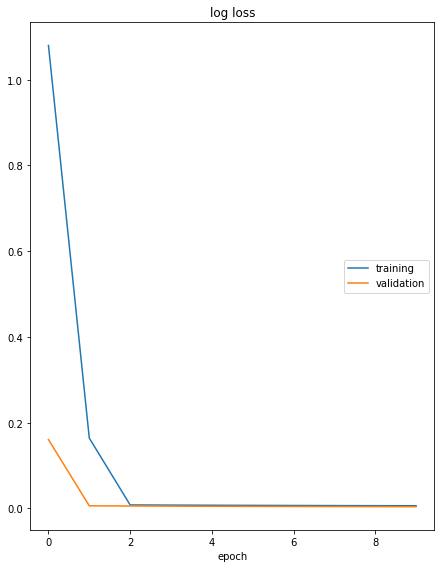

log loss
	training         	 (min:    0.006, max:    1.080, cur:    0.006)
	validation       	 (min:    0.004, max:    0.161, cur:    0.004)

 Number of parameters:  55322669
Time taken:  211.5826222896576


In [17]:
start = time.time()

latent_space_dim = 16

model_name = 'latDim16'

model1, results_models[model_name] = train_top_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type='classic_AE_variant2', 
                                                num_epochs=num_epochs, device=preferred_device)

end = time.time()

print('Time taken: ',end-start) 

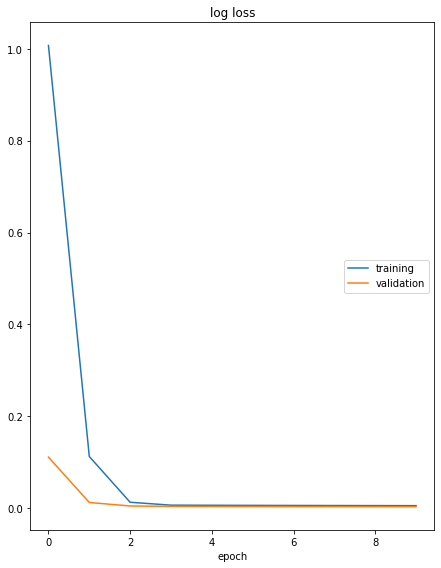

log loss
	training         	 (min:    0.005, max:    1.007, cur:    0.005)
	validation       	 (min:    0.003, max:    0.111, cur:    0.003)

 Number of parameters:  109796285
Time taken:  244.88255882263184


In [18]:
start = time.time()

latent_space_dim = 32

model_name = 'latDim32'

model2, results_models[model_name] = train_top_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type='classic_AE_variant2', 
                                                num_epochs=num_epochs, device=preferred_device)

end = time.time()

print('Time taken: ',end-start) 

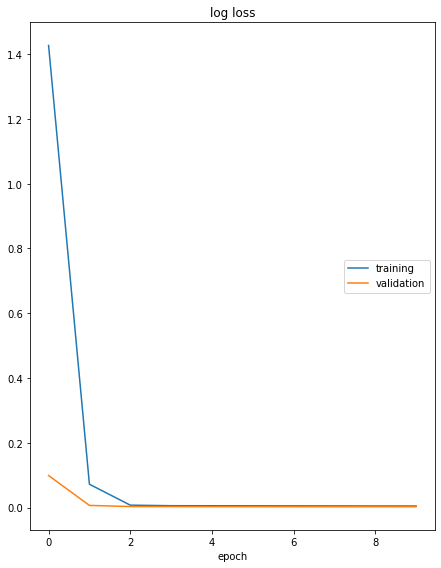

log loss
	training         	 (min:    0.005, max:    1.427, cur:    0.005)
	validation       	 (min:    0.003, max:    0.099, cur:    0.003)

 Number of parameters:  218749661
Time taken:  310.71449613571167


In [19]:
start = time.time()

latent_space_dim = 64

model_name = 'latDim64'

model3, results_models[model_name] = train_top_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type='classic_AE_variant2', 
                                                num_epochs=num_epochs, device=preferred_device)

end = time.time()

print('Time taken: ',end-start) 

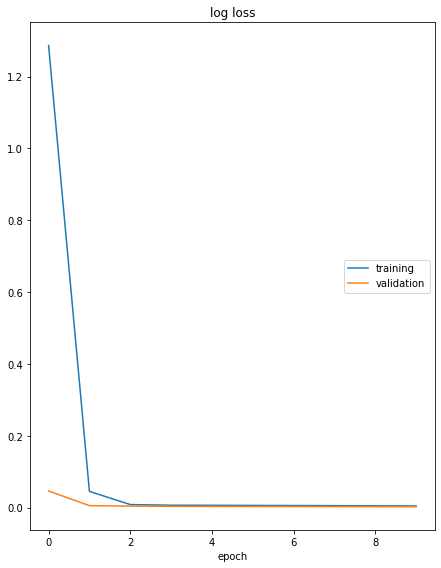

log loss
	training         	 (min:    0.004, max:    1.287, cur:    0.004)
	validation       	 (min:    0.002, max:    0.046, cur:    0.002)

 Number of parameters:  436680989
Time taken:  421.6121916770935


In [20]:
start = time.time()

latent_space_dim = 128

model_name = 'latDim128'

model4, results_models[model_name] = train_top_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type='classic_AE_variant2', 
                                                num_epochs=num_epochs, device=preferred_device)

end = time.time()

print('Time taken: ',end-start) 

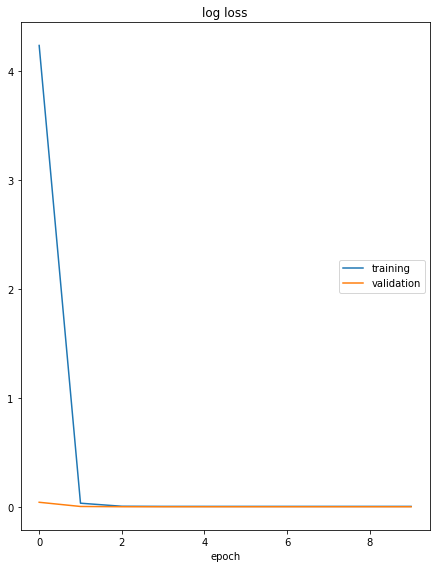

log loss
	training         	 (min:    0.007, max:    4.234, cur:    0.007)
	validation       	 (min:    0.004, max:    0.045, cur:    0.004)

 Number of parameters:  872641949
Time taken:  1006.8593363761902


In [21]:
start = time.time()

latent_space_dim = 256

model_name = 'latDim256'

model5, results_models[model_name] = train_top_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type='classic_AE_variant2', 
                                                num_epochs=num_epochs, device=preferred_device)

end = time.time()

print('Time taken: ',end-start) 

## MSE results

In [22]:
sys.path.insert(0, '../../auxiliary_scripts')

from rank_models import plot_losses , rank_losses

In [23]:
models_names = list( results_models.keys() )

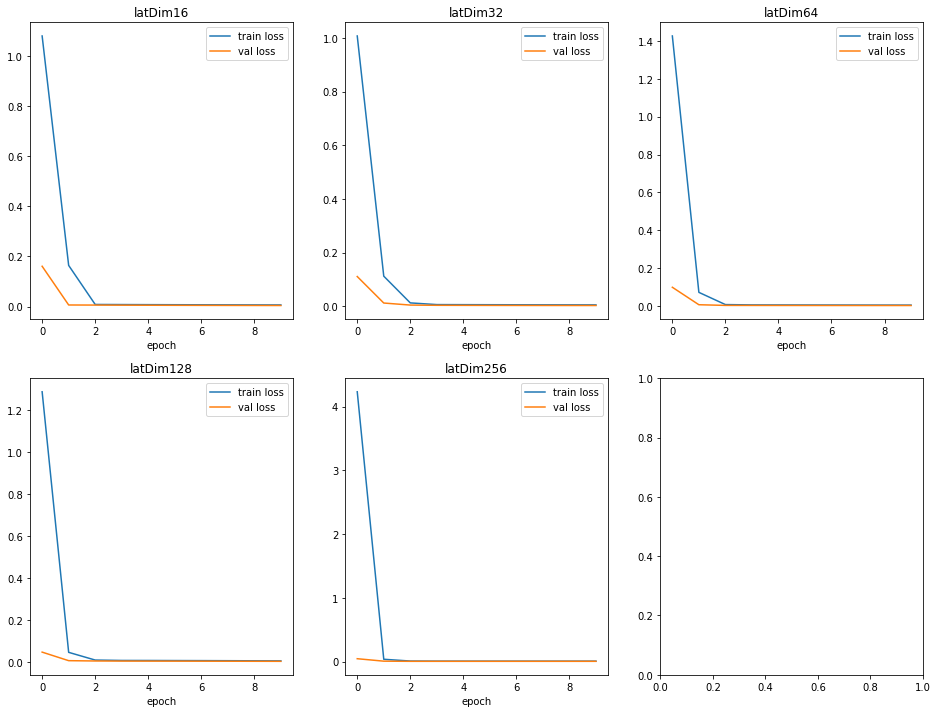

In [24]:
filename = 'classic_AE_variant2_WaveSuite'+'_diffLatDim_losses.png'
plot_losses(results_models, models_names, figsize=(16,12), filename=filename)

In [25]:
rank_losses(results_models, models_names, selected_epoch = int(num_epochs/4) )

,variants_name,final_validation_loss
0,latDim128,0.005455
1,latDim16,0.006131
2,latDim256,0.006169
3,latDim64,0.006958
4,latDim32,0.012298


In [26]:
rank_losses(results_models, models_names, selected_epoch = int(num_epochs/2) )

,variants_name,final_validation_loss
0,latDim64,0.003154
1,latDim128,0.003313
2,latDim32,0.003638
3,latDim256,0.003707
4,latDim16,0.005105


In [27]:
first_column_model_name = 'classic_AE_variant2'
filename = 'classic_AE_variant2_WaveSuite'+'_diffLatDim_losses.csv'

df_losses = rank_losses(results_models, models_names, selected_epoch = num_epochs,
                       first_column_model_name = first_column_model_name, filename = filename )

df_losses

CSV was saved


,Model name,variants_name,final_validation_loss
0,classic_AE_variant2,latDim128,0.002333
1,classic_AE_variant2,latDim64,0.002842
2,classic_AE_variant2,latDim32,0.003054
3,classic_AE_variant2,latDim256,0.003706
4,classic_AE_variant2,latDim16,0.004026


# Plot the results

In [28]:
from plot_results_3D_vtu import compare_three_plots_models_3D_vtu

In [29]:
filename_to_copy_structure = '../../../Datasets/WaveSuite_VTK/sateNo4_1_51.vtu'

Indexes plotted [5 0 4 2 1 3]


C:\Users\angel\Anaconda3\envs\second-try-alienware\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


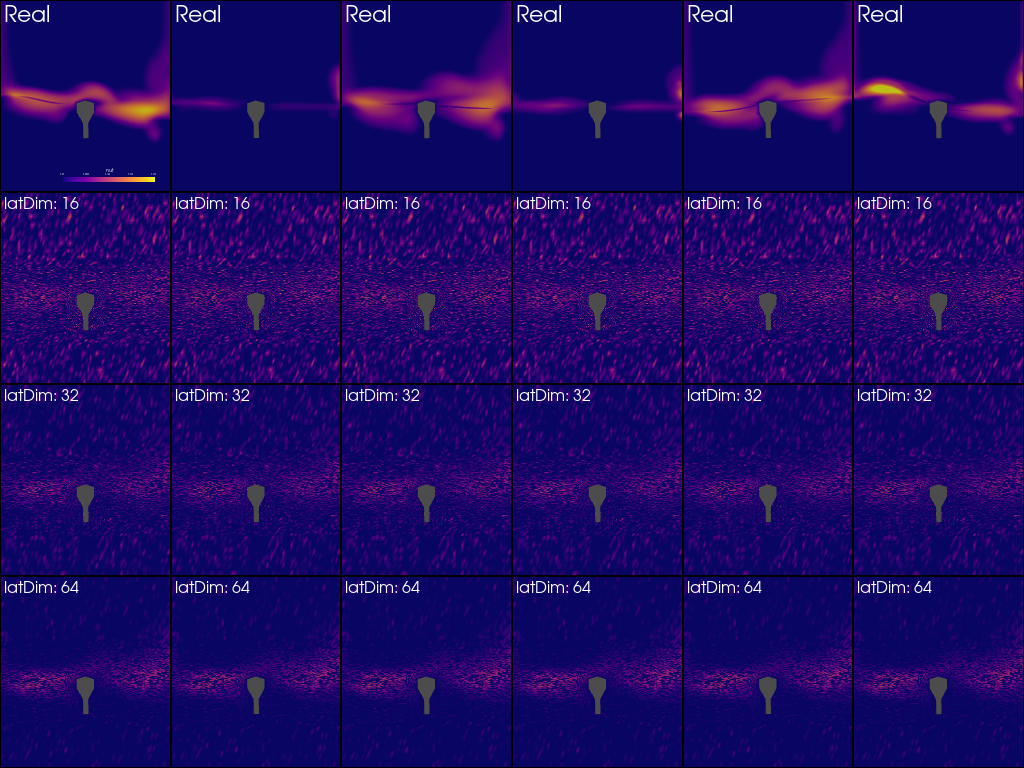

In [30]:
compare_three_plots_models_3D_vtu(model1, model2, model3, 
                                wavesuite_object_test, 6, filename_to_copy_structure, 
                                      feature_select=features_list[0], 
                                       device = preferred_device, 
                                 set_pred_labels_as = ["latDim: 16", "latDim: 32", "latDim: 64"],
                            save_fig=True, filename='classic_AE_variant2_WaveSuite_diffLatDim_16to64.eps'  ) 

Indexes plotted [0 5 4 3 2 1]


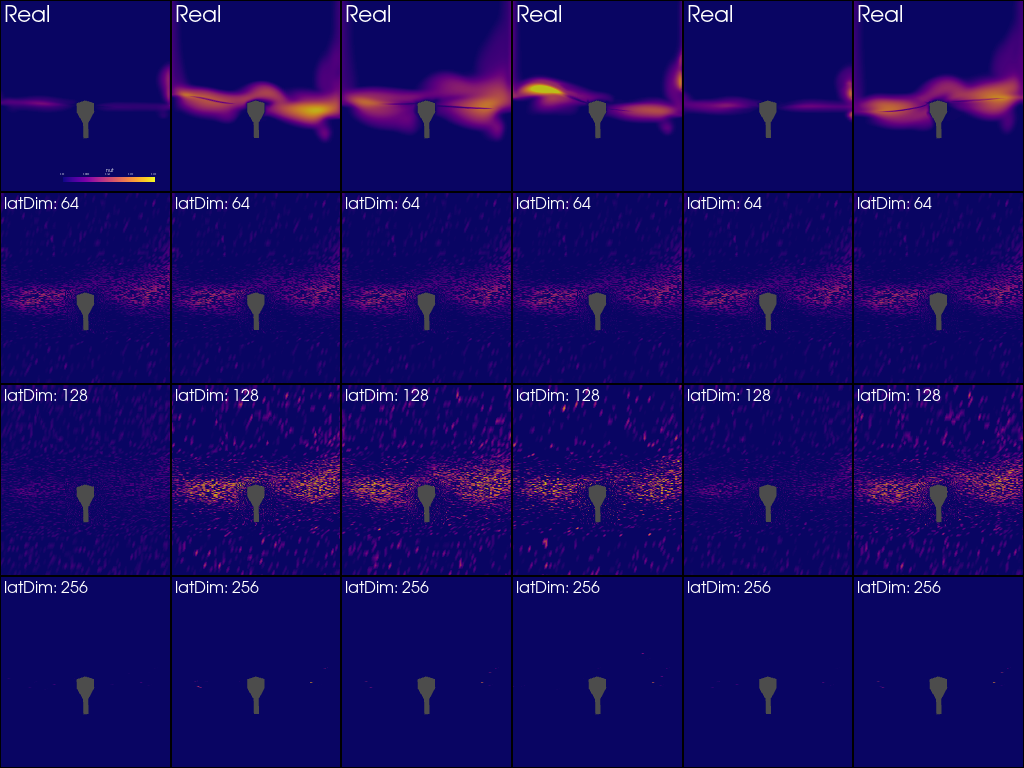

In [34]:
compare_three_plots_models_3D_vtu(model3, model4, model5,
                                wavesuite_object_test, 6, filename_to_copy_structure, 
                                      feature_select=features_list[0], 
                                       device = preferred_device, 
                                 set_pred_labels_as = ["latDim: 64", "latDim: 128", "latDim: 256"]
                            ,save_fig=True, filename='classic_AE_variant2_WaveSuite_diffLatDim_64to256.eps' 
                                 ) 

## Save best models parameters just in case

In [35]:
PATH = 'saved_model_parameters/classic_AE_variant2_latDim64.pkl'  
torch.save(model3, PATH)

In [36]:
PATH = 'saved_model_parameters/classic_AE_variant2_latDim128.pkl'  
torch.save(model4, PATH)

In [37]:
PATH = 'saved_model_parameters/classic_AE_variant2_latDim256.pkl'  
torch.save(model5, PATH)

In [ ]:
import winsound
from time import sleep

# winsound.PlaySound("SystemExplanation", winsound.SND_ALIAS)
winsound.Beep(440, 500)
sleep(3)
winsound.Beep(440, 500)
sleep(3)
winsound.Beep(440, 500)